##Final Project by Ishita Gupta (ID: 49003344)

###Requirements:
> This is a semi supervised learning method based on Ladder variational autoencoder . 
Paper link : https://openreview.net/forum?id=Sy2fzU9gl
This is implementing with the help of the following repository : https://github.com/wohlert/semi-supervised-pytorch

My added part : The CIFAR dataset class at https://colab.research.google.com/drive/1VWtCAYwaVHC7vIGhXD_kEyIFXEZMOftG#scrollTo=D-GF1ihM1WTB&line=3&uniqifier=1

(However there are currently some errors in adapting this to CIFAR dataset, it works on the MNIST dataset)



In [9]:
# Imports
import torch
cuda = torch.cuda.is_available()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../../semi-supervised")
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from keras import layers
from keras import optimizers


Using TensorFlow backend.


In [2]:
!git clone https://github.com/wohlert/semi-supervised-pytorch.git

fatal: destination path 'semi-supervised-pytorch' already exists and is not an empty directory.


In [3]:
!ls

sample_data  semi-supervised-pytorch


In [4]:
%cd ./semi-supervised-pytorch/semi-supervised/

/content/semi-supervised-pytorch/semi-supervised


In [5]:
%ls

inference/  layers/  models/  utils.py


# Ladder Variational Autoencoder

The ladder variational autoencoder (LVAE) [[Sønderby 2016a]](https://arxiv.org/abs/1602.02282) adds several stochastic layers to the VAE and performs both bottom-up and top-down merging of information to provide a better estimate of the log likelihood of data. The model is non-trivial, as evidenced by the diagram below.

<img src="https://github.com/wohlert/semi-supervised-pytorch/blob/master/examples/images/ladder.png?raw=1" width="300px"/>

Where left is the inference model and right is the generative model. The number of stochastic layers is not predetermined and can be chosen to be any number as long as the two parts agree.

In [6]:
from models import LadderVariationalAutoencoder

# Bottom to top
z_dim = [32, 16, 8]
h_dim = [256, 128, 64]

model = LadderVariationalAutoencoder([784, z_dim, h_dim])
model

/content/semi-supervised-pytorch/semi-supervised/models/vae.py:114: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)
/content/semi-supervised-pytorch/semi-supervised/models/vae.py:307: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)


LadderVariationalAutoencoder(
  (encoder): ModuleList(
    (0): LadderEncoder(
      (linear): Linear(in_features=784, out_features=256, bias=True)
      (batchnorm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (sample): GaussianSample(
        (mu): Linear(in_features=256, out_features=32, bias=True)
        (log_var): Linear(in_features=256, out_features=32, bias=True)
      )
    )
    (1): LadderEncoder(
      (linear): Linear(in_features=256, out_features=128, bias=True)
      (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (sample): GaussianSample(
        (mu): Linear(in_features=128, out_features=16, bias=True)
        (log_var): Linear(in_features=128, out_features=16, bias=True)
      )
    )
    (2): LadderEncoder(
      (linear): Linear(in_features=128, out_features=64, bias=True)
      (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## Training

We still want to maximise the same lower bound as described in the VAE notebook, the difference here is that both the generative model and the inference model are now hierarchical.

$$p_{\theta}(z) = p_{\theta}(z_L) \prod_{i=1}^{L-1} p_{\theta}(z_i|z_{i+1})$$
$$q_{\phi}(z|x) = q_{\phi}(z_1|x) \prod_{i=2}^{L} q_{\phi}(z_i|z_{i+1})$$

Which results in a KL-divergence between the latent distributions of their respective p and q layers. All of this is handled directly within the model.

Additionally, training hierarchical deep generative models is prone to collapsing fo the stochastic units - meaning that these become inactive during training. This problem can be avoided by gradually turning on the KL-term during turning [[Sønderby 2016b]](http://orbit.dtu.dk/files/121765928/1602.02282.pdf). Typically one starts out training the model with no, or little influence of the KL-term ($\beta \approxeq 0$). Then after each epoch, the temperature is raised to $\beta = 1$.

This warm-up scheme has been implemented as an iterator as `DeterministicWarmup`.

In [0]:
%ls

'Auxiliary Deep Generative Model.ipynb'  'Gumbel Softmax.ipynb'
'Beta Variational Autoencoder.ipynb'     'Ladder Deep Generative Model.ipynb'
 datautils.py                            'Ladder Variational Autoencoder.ipynb'
'Deep Generative Model.ipynb'            'Variational Autoencoder.ipynb'


In [0]:
#Dataset 
def CIFARdataset(train_size):
  #load_data
  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  totalset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
  
  testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform)

  total_length=int(train_size* len(totalset))
  total_dataset,no_train_dataset=torch.utils.data.random_split(totalset,(total_length,len(totalset)-total_length))
  train_length=int(0.8* len(total_dataset))
  train_dataset,val_dataset=torch.utils.data.random_split(total_dataset,(train_length,len(total_dataset)-train_length))

  trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                            shuffle=True, num_workers=2)
  
  valloader = torch.utils.data.DataLoader(val_dataset, batch_size=128,
                                            shuffle=True, num_workers=2)

  testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                          shuffle=True, num_workers=2)


  return trainloader, valloader, testloader 

In [12]:
%cd ..

/content/semi-supervised-pytorch


In [13]:
%cd ./examples/notebooks/

/content/semi-supervised-pytorch/examples/notebooks


In [16]:
from datautils import get_mnist
from inference import DeterministicWarmup

#train, validation, testloader=CIFARdataset(1.0) 
_, train, validation = get_mnist(location="./", batch_size=64)

def binary_cross_entropy(r, x):
    return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))
beta = DeterministicWarmup(n=50, t_max=1) # Linear warm-up from 0 to 1 over 50 epochs


0it [00:00, ?it/s]


 73%|███████▎  | 7217152/9912422 [00:02<00:02, 999013.83it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




0it [00:00, ?it/s]



  0%|          | 0/28881 [00:00<?, ?it/s]

 57%|█████▋    | 16384/28881 [00:00<00:00, 86522.31it/s]

32768it [00:00, 57367.77it/s]                           

0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




  0%|          | 0/1648877 [00:00<?, ?it/s]

  1%|          | 16384/1648877 [00:00<00:21, 75863.55it/s]

  2%|▏         | 40960/1648877 [00:00<00:18, 87025.92it/s]

  6%|▌         | 98304/1648877 [00:00<00:13, 110814.02it/s]

 13%|█▎        | 212992/1648877 [00:01<00:09, 147004.35it/s]

 26%|██▌       | 425984/1648877 [00:01<00:06, 199188.90it/s]

 38%|███▊      | 622592/1648877 [00:01<00:03, 263547.54it/s]

 51%|█████     | 843776/1648877 [00:01<00:02, 344274.69it/s]

 93%|█████████▎| 1540096/1648877 [00:01<00:00, 473419.21it/s]

1654784it [00:01, 867352.89it/s]                             

0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




  0%|          | 0/4542 [00:00<?, ?it/s]

8192it [00:00, 21603.32it/s]            /usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [17]:
from torch.autograd import Variable

for epoch in range(50):
    model.train()
    total_loss = 0
    for (u, _) in train:
        u = Variable(u)

        u= u.cuda()
        model= model.cuda()

        reconstruction = model(u)
        
        likelihood = -binary_cross_entropy(reconstruction, u)
        elbo = likelihood - next(beta) * model.kl_divergence
        
        L = -torch.mean(elbo)

        L.backward()
        optimizer.step()
        optimizer.zero_grad()
         
        total_loss += L.item()

    m = len(train)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch+1}\tL: {total_loss/m:.2f}")


9920512it [00:20, 999013.83it/s]                             

Epoch: 1	L: 217.73
Epoch: 11	L: 166.08
Epoch: 21	L: 157.42
Epoch: 31	L: 153.82
Epoch: 41	L: 151.56


## Sampling from the generative model

To sample from the network we pass some normal distributed noise $z \sim N(0, I)$ to the top most layer of the decoder and pass the representation through the layers to arrive at our final generated data.

In [0]:
model.eval()
x_mu = model.sample(Variable(torch.randn(16, 8)).cuda())

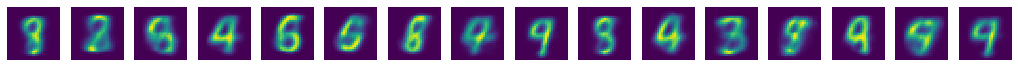

In [0]:
f, axarr = plt.subplots(1, 16, figsize=(18, 12))

samples = x_mu.data.view(-1, 28, 28).cpu().numpy()

for i, ax in enumerate(axarr.flat):
    ax.imshow(samples[i])
    ax.axis("off")